# Prophet

https://facebook.github.io/prophet/docs/quick_start.html

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.


python: "3.8"
build_dependencies:
  - pip
dependencies:
  - prophet>=1.0.1

OPtional plotly ipywidgets

In [1]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
import pandas as pd
# set the experiment id
mlflow.set_tracking_uri("http://localhost:5000") 
experiment_name = "prophet"
try:
    mlflow.create_experiment(experiment_name)
except:
    print("experiment exists")
mlflow.set_experiment(experiment_name)

mlflow.sklearn.autolog(disable_for_unsupported_versions=True)

experiment exists


In [2]:
import json

import numpy as np
import pandas as pd
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation, performance_metrics

import mlflow
from mlflow.models import infer_signature

SOURCE_DATA = (
    "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
)
ARTIFACT_PATH = "model"
np.random.seed(12345)

In [3]:
def extract_params(pr_model):
    return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}


sales_data = pd.read_csv(SOURCE_DATA)

In [15]:
sales_data.tail()

,ds,y
288,2016-01-01,400928
289,2016-02-01,413554
290,2016-03-01,460093
291,2016-04-01,450935
292,2016-05-01,471421


In [22]:
sales_data.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [14]:
len(sales_data)

293

In [5]:
with mlflow.start_run():
    model = Prophet().fit(sales_data)

    params = extract_params(model)

    metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
    metrics_raw = cross_validation(
        model=model,
        horizon="365 days",
        period="180 days",
        initial="710 days",
        parallel="threads",
        disable_tqdm=True,
    )
    cv_metrics = performance_metrics(metrics_raw)
    metrics = {k: cv_metrics[k].mean() for k in metric_keys}

    print(f"Logged Metrics: \n{json.dumps(metrics, indent=2)}")
    print(f"Logged Params: \n{json.dumps(params, indent=2)}")

    train = model.history
    predictions = model.predict(model.make_future_dataframe(30))
    signature = infer_signature(train, predictions)

    mlflow.prophet.log_model(model, artifact_path=ARTIFACT_PATH, signature=signature)
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    model_uri = mlflow.get_artifact_uri(ARTIFACT_PATH)
    print(f"Model artifact logged to: {model_uri}")



06:55:34 - cmdstanpy - INFO - Chain [1] start processing
06:55:34 - cmdstanpy - INFO - Chain [1] done processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Chain [1] start processing
06:55:36 - cmdstanpy - INFO - Ch

Logged Metrics: 
{
  "mse": 338741019.34975183,
  "rmse": 18127.619589380036,
  "mae": 12539.758203487183,
  "mape": 0.03689890395374471,
  "mdape": 0.02545312717668932,
  "smape": 0.03672036984843507,
  "coverage": 0.38000875201059703
}
Logged Params: 
{
  "growth": "linear",
  "n_changepoints": 25,
  "specified_changepoints": false,
  "changepoint_range": 0.8,
  "yearly_seasonality": "auto",
  "weekly_seasonality": "auto",
  "daily_seasonality": "auto",
  "seasonality_mode": "additive",
  "seasonality_prior_scale": 10.0,
  "changepoint_prior_scale": 0.05,
  "holidays_prior_scale": 10.0,
  "mcmc_samples": 0,
  "interval_width": 0.8,
  "uncertainty_samples": 1000,
  "y_scale": 518253.0,
  "y_min": 0.0,
  "scaling": "absmax",
  "logistic_floor": false,
  "country_holidays": null,
  "component_modes": {
    "additive": [
      "yearly",
      "additive_terms",
      "extra_regressors_additive",
      "holidays"
    ],
    "multiplicative": [
      "multiplicative_terms",
      "extra_reg

In [9]:
mlflow.end_run()

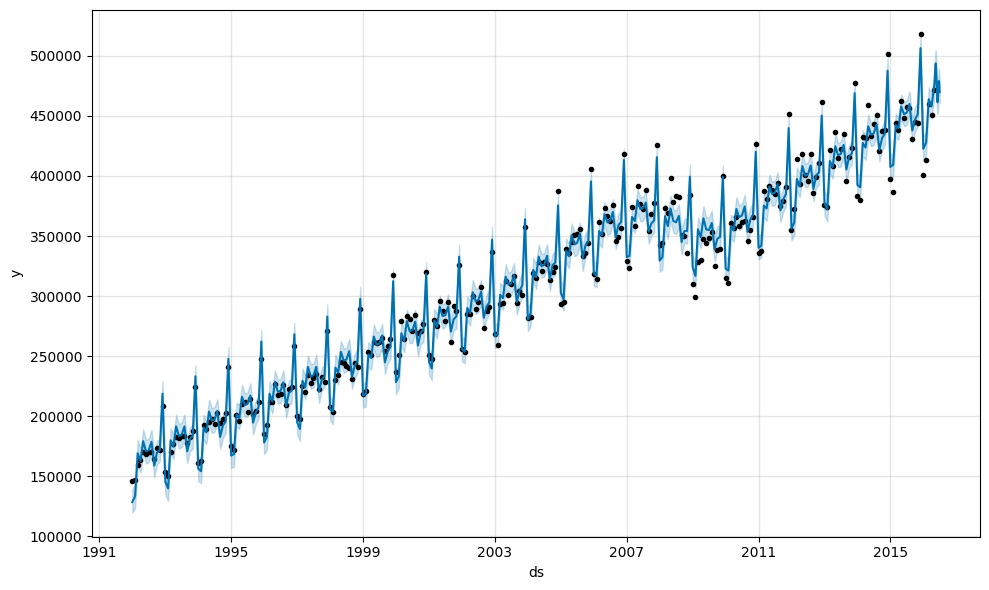

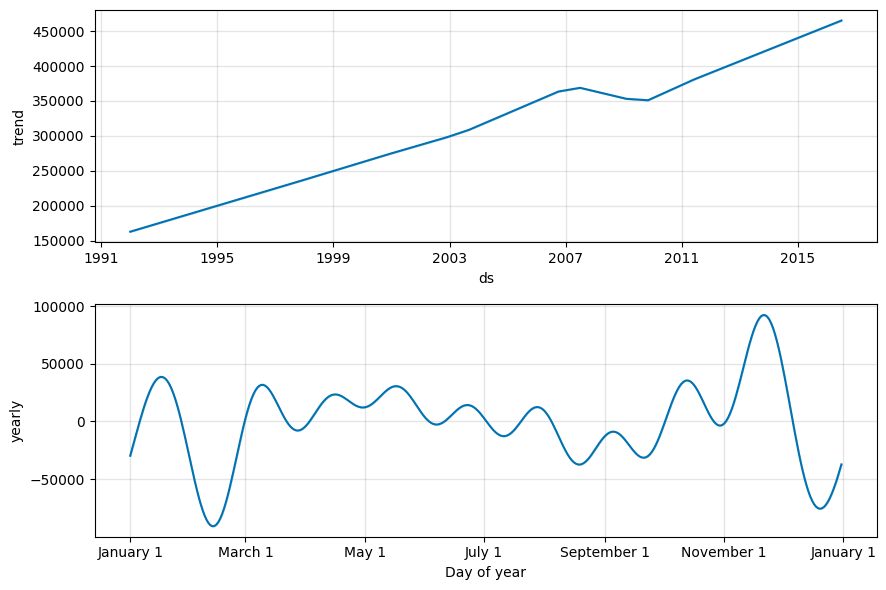

In [23]:
from datetime import datetime

## Define the name of our run
name = "predictions" + datetime.now().strftime("%Y-%m-%d")
with mlflow.start_run(run_name = name):
    loaded_model = mlflow.prophet.load_model(model_uri)
    
    forecast = loaded_model.predict(loaded_model.make_future_dataframe(60))
    forecast.to_csv("forecats.csv")
    mlflow.log_artifact('forecats.csv', "datasets")
    fig1 = loaded_model.plot(forecast)
    mlflow.log_figure(fig1, 'plot_forecats.png')
    fig2 = model.plot_components(forecast)
    mlflow.log_figure(fig2, 'plot_forecats_components.png')
    
    



In [24]:
type(forecast)

pandas.core.frame.DataFrame

In [25]:
len(forecast)

353

In [21]:
forecast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
351,2016-06-29,465034.472868,461542.318292,481644.853457,465034.472868,465034.472868,6863.299237,6863.299237,6863.299237,6863.299237,6863.299237,6863.299237,0.0,0.0,0.0,471897.772105
352,2016-06-30,465079.988983,459872.233469,480149.694317,465079.988983,465079.988983,4759.264949,4759.264949,4759.264949,4759.264949,4759.264949,4759.264949,0.0,0.0,0.0,469839.253932


In [20]:
forecast[-60:].head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
293,2016-05-02,462394.538202,463576.747182,485074.441173,462394.538202,462394.538202,12862.429626,12862.429626,12862.429626,12862.429626,12862.429626,12862.429626,0.0,0.0,0.0,475256.967828
294,2016-05-03,462440.054317,465929.266259,485086.164045,462440.054317,462440.054317,13620.158018,13620.158018,13620.158018,13620.158018,13620.158018,13620.158018,0.0,0.0,0.0,476060.212335
295,2016-05-04,462485.570432,466864.013460,486811.728985,462485.570432,462485.570432,14631.454777,14631.454777,14631.454777,14631.454777,14631.454777,14631.454777,0.0,0.0,0.0,477117.025209
296,2016-05-05,462531.086547,467720.102913,488409.808817,462531.086547,462531.086547,15867.647360,15867.647360,15867.647360,15867.647360,15867.647360,15867.647360,0.0,0.0,0.0,478398.733907
297,2016-05-06,462576.602662,469960.290376,490276.088088,462576.602662,462576.602662,17291.619150,17291.619150,17291.619150,17291.619150,17291.619150,17291.619150,0.0,0.0,0.0,479868.221812


In [11]:
mlflow.end_run()